In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from load_data import load_city_data

In [2]:
data = load_city_data("Philadelphia")
business_df = data["businesses"]
reviews_df = data["reviews"]

# Quick overview

Let's start by looking at the data from bird's eye view. This is to get a general sense of the data. Additionally, before exploring the `reviews_df` further, we need to make sure to split it into a train and test set, so as not to make biased observations based on the data from the test set.


In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967552 entries, 0 to 967551
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    967552 non-null  object 
 1   user_id      967552 non-null  object 
 2   business_id  967552 non-null  object 
 3   stars        967552 non-null  float64
 4   useful       967552 non-null  int64  
 5   funny        967552 non-null  int64  
 6   cool         967552 non-null  int64  
 7   text         967552 non-null  object 
 8   date         967552 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 66.4+ MB


In [4]:
reviews_df.describe()

,stars,useful,funny,cool
count,967552.000000,967552.000000,967552.000000,967552.000000
mean,3.785673,1.297061,0.404695,0.574951
std,1.388208,3.018767,1.703304,2.098239
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,320.000000,284.000000,192.000000


For reviews, the only two useful columns we can work with are `stars` and `text`. `stars` is of course the target variable, so `text` is the only real attribute we will use here. It will be used to construct user profiles using NLP techniques, which will in turn be used to aid predictions of the models. The reason we omit other attributes, (`useful`, `funny`, `cool`) is because they are inherently tied to the review, which we do not directly use, so there is no good way for us to use them in a beneficial manner. Furthermore, beside signaling how helpful the user's reviews are in general, they do not help in recommending new items to the user.


In [5]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14569 entries, 0 to 14568
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   14569 non-null  object 
 1   name          14569 non-null  object 
 2   address       14569 non-null  object 
 3   city          14569 non-null  object 
 4   state         14569 non-null  object 
 5   postal_code   14569 non-null  object 
 6   latitude      14569 non-null  float64
 7   longitude     14569 non-null  float64
 8   stars         14569 non-null  float64
 9   review_count  14569 non-null  int64  
 10  is_open       14569 non-null  int64  
 11  attributes    13399 non-null  object 
 12  categories    14560 non-null  object 
 13  hours         11785 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 1.6+ MB


In [6]:
business_df.describe()

,latitude,longitude,stars,review_count,is_open
count,14569.000000,14569.000000,14569.000000,14569.000000,14569.000000
mean,39.976458,-75.152681,3.623035,64.262475,0.723591
std,0.049547,0.053926,0.960691,165.301869,0.447237
min,39.864924,-75.651673,1.000000,5.000000,0.000000
25%,39.948050,-75.175764,3.000000,9.000000,0.000000
50%,39.954384,-75.161018,4.000000,19.000000,1.000000
75%,40.008115,-75.143919,4.500000,53.000000,1.000000
max,40.247267,-74.893799,5.000000,5721.000000,1.000000


Here we observe a few more useful attributes. Namely, `latitude` and `longtitude` could be useful if it turns out that there is a part of a city where good/bad restaurants tend to cluster; we believe `stars` could be the biggest predictor of how users grade the items, as this is how it usually is in real life; `review_count` may also prove to be beneficial, as popular things are _usually_ popular because they are generally a good thing (please exclude fidget spinners and other stupid trends from this line of reasoning); `attributes` are open to further inspection; `categories` directly classify businesses, and make a good feature; `hours` should strictly speaking not affect the rating of the restaurant, as it is more a factor of when we want to visit a business, not what kind of quality we are looking for, but alas.

As for `is_open`, we will assume all businesses are open to simplify are task somewhat. We realise we somewhat shut our eyes to the real world and the big picture, but to simplify the task we just pretend we didn't even have this attribute in the first place. In any case, should we want to make predictions for only the open restaurants, we could simply filter the businesses that are currently open, and corresponding reviews. However, this would rob us of valuable training data, which we are not willing to part with. Second consideration is that we could simply remove the closed businesses from the recommendation list after training on the whole dataset (this actually provides the most suitable solution).

Other attributes being `name`, `address`, `city`, `state`, `postal_code` should hopefully be self-explanatory for why they are useless. A not for the last three mentioned: we have limited ourselves to only one city, so the values are the same for all instances.


## Making sense of `categories`


In [7]:
business_df["categories"] = business_df["categories"].str.split(", ")

In [ ]:
flattened_categories = [
    item for sublist in business_df["categories"].dropna() for item in sublist
]

# how many different categories are there?
print(f"There are {len(set(flattened_categories))} unique categories.")

# what are their counts?
counts = Counter(flattened_categories)
print("The most common categories are:")
print(counts.most_common(50))

There are 1027 unique categories.
The most common categories are:
[('Restaurants', 5852), ('Food', 3105), ('Shopping', 2091), ('Nightlife', 1463), ('Beauty & Spas', 1320), ('Bars', 1293), ('Home Services', 1151), ('Local Services', 1013), ('Health & Medical', 984), ('Sandwiches', 929), ('Coffee & Tea', 894), ('Event Planning & Services', 819), ('Pizza', 800), ('American (New)', 751), ('Breakfast & Brunch', 686), ('Automotive', 665), ('American (Traditional)', 663), ('Active Life', 643), ('Arts & Entertainment', 595), ('Fashion', 535), ('Hair Salons', 532), ('Italian', 505), ('Specialty Food', 482), ('Chinese', 471), ('Nail Salons', 395), ('Hotels & Travel', 392), ('Real Estate', 376), ('Professional Services', 375), ('Bakeries', 373), ('Fast Food', 367), ('Home & Garden', 364), ('Burgers', 363), ('Seafood', 359), ('Fitness & Instruction', 353), ('Desserts', 344), ('Grocery', 329), ('Cafes', 323), ('Auto Repair', 322), ('Mexican', 315), ('Delis', 308), ('Caterers', 294), ('Salad', 280),

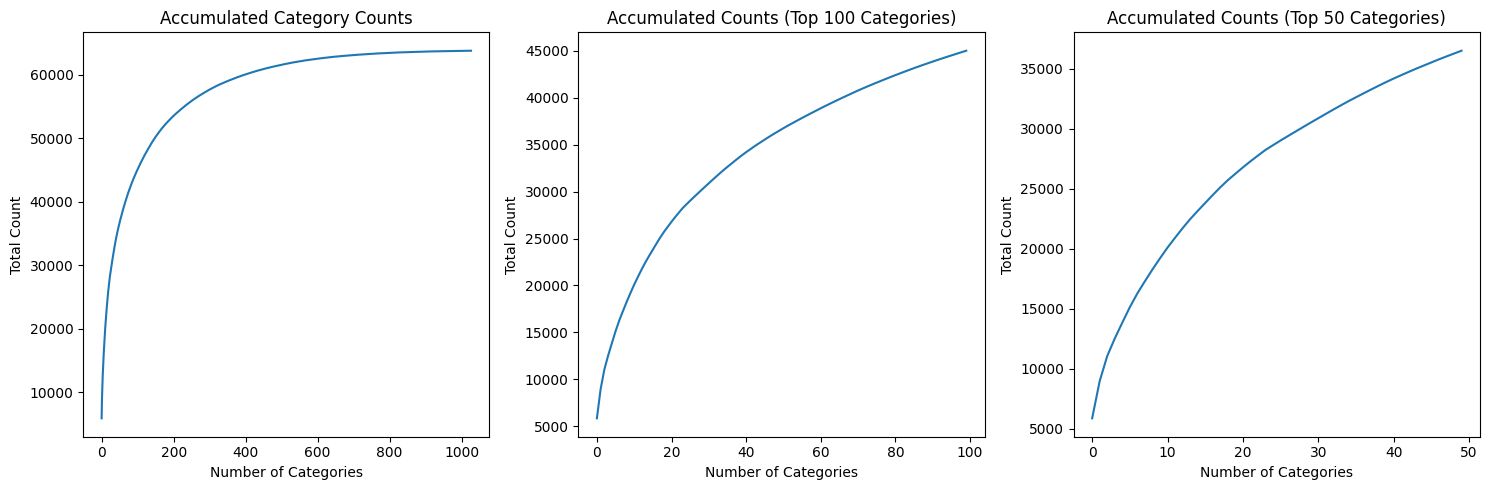

In [ ]:
accumulative_categories_counts = [
    sum(count for _, count in counts.most_common(i)) for i in range(1, len(counts) + 1)
]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

ax[0].plot(accumulative_categories_counts)
ax[0].set_title("Accumulated Category Counts")
ax[0].set_xlabel("Number of Categories")
ax[0].set_ylabel("Total Count")

ax[1].plot(accumulative_categories_counts[:100])
ax[1].set_title("Accumulated Counts (Top 100 Categories)")
ax[1].set_xlabel("Number of Categories")
ax[1].set_ylabel("Total Count")

ax[2].plot(accumulative_categories_counts[:50])
ax[2].set_title("Accumulated Counts (Top 50 Categories)")
ax[2].set_xlabel("Number of Categories")
ax[2].set_ylabel("Total Count")

plt.tight_layout()
plt.show()

We will limit ourselves only to gastronomy related establishments.


In [ ]:
business_df["categories"] = business_df["categories"].apply(
    lambda x: ", ".join(x) if x is not None else ""
)

In [12]:
from sentence_transformers import SentenceTransformer, util

# noinspection PyTypeChecker
embedder = SentenceTransformer("all-MiniLM-L6-v2")
anchor = "food, restaurant, eating, drinking"
anchor_embedding = embedder.encode(anchor, convert_to_numpy=True)
business_categories_embeddings = embedder.encode(
    business_df["categories"].values, convert_to_numpy=True
)
similarities = util.cos_sim(anchor_embedding, business_categories_embeddings).numpy()

In [13]:
threshold = 0.6
mask = (similarities >= threshold).flatten()
restaurant_df = business_df[mask]
restaurant_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1..."
5,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","Eatertainment, Arts & Entertainment, Brewpubs,...","{'Monday': '0:0-0:0', 'Wednesday': '16:0-22:0'..."
6,-4dYswJy7SPcbcERvitmIg,Pathmark,3021 Grays Ferry Ave,Philadelphia,PA,19146,39.940403,-75.193297,2.5,34,0,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Food, Grocery","{'Monday': '6:0-1:0', 'Tuesday': '6:0-1:0', 'W..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14554,K1SsvIPfFcHniNSPc3IG7g,Flip-N-Pizza,1308 W Girard Ave,Philadelphia,PA,19123,39.970720,-75.157752,4.0,16,1,"{'WiFi': 'u'no'', 'BYOB': 'False', 'Restaurant...","Restaurants, American (Traditional), Chicken W...","{'Monday': '0:0-0:0', 'Tuesday': '15:0-1:30', ..."
14557,mzTTdvQGkUHZ8ii7OnZC5w,Trader Joe's,2121 Market St,Philadelphia,PA,19103,39.954178,-75.175980,4.0,494,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Beer, Wine & Spirits, Shopping, Grocery, Flori...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."
14562,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,Philadelphia,PA,19128,40.032483,-75.214430,3.0,55,1,"{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...","Restaurants, Specialty Food, Food, Sandwiches,...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
14563,8n93L-ilMAsvwUatarykSg,Kitchen Gia,3716 Spruce St,Philadelphia,PA,19104,39.951018,-75.198240,3.0,22,0,"{'RestaurantsGoodForGroups': 'True', 'BikePark...","Coffee & Tea, Food, Sandwiches, American (Trad...","{'Monday': '9:0-19:30', 'Tuesday': '9:0-19:30'..."


In [14]:
print(
    f'There are {len(restaurant_df)} restaurants and {reviews_df["business_id"].isin(set(restaurant_df["business_id"])).to_numpy().sum()} reviews for them.'
)

There are 3304 restaurants and 326073 reviews for them.


# Exploring `restaurant_df`


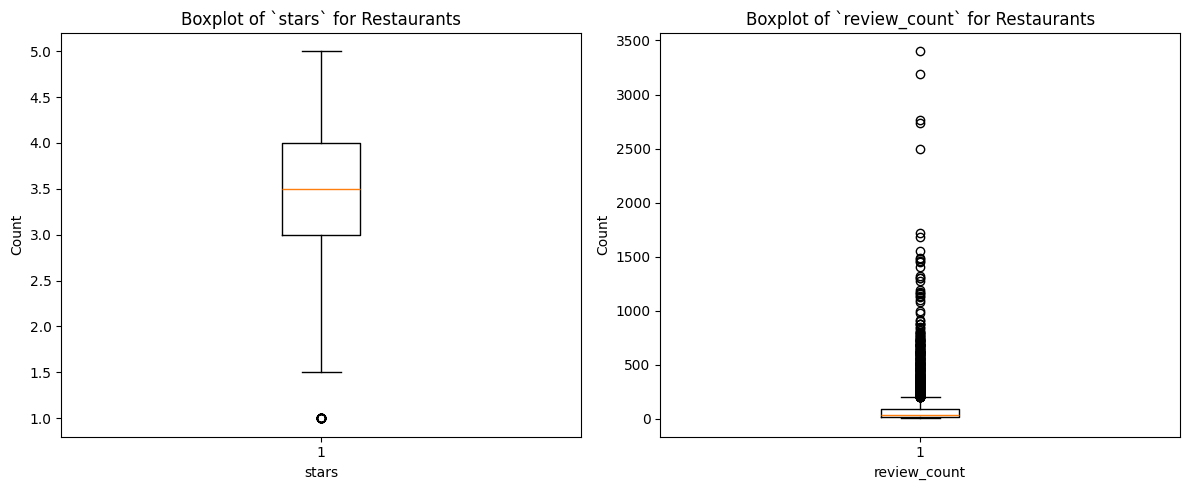

In [18]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].boxplot(restaurant_df["stars"])
ax[0].set_title("Boxplot of `stars` for Restaurants")
ax[0].set_xlabel("stars")
ax[0].set_ylabel("Count")

ax[1].boxplot(restaurant_df["review_count"])
ax[1].set_title("Boxplot of `review_count` for Restaurants")
ax[1].set_xlabel("review_count")
ax[1].set_ylabel("Count")

# ax[2].hist(restaurant_df["is_open"], bins=2, edgecolor="black")
# ax[2].set_title("Histogram of `is_open` for Restaurants")
# ax[2].set_xlabel("is_open")
# ax[2].set_ylabel("Count")
# ax[2].set_xticks([0, 1], ["Closed", "Open"])

plt.tight_layout()
plt.show()

In [ ]:
restaurant_df["stars"].value_counts()

stars
4.0    798
3.5    705
3.0    562
4.5    477
2.5    336
2.0    224
1.5    106
5.0     71
1.0     25
Name: count, dtype: int64

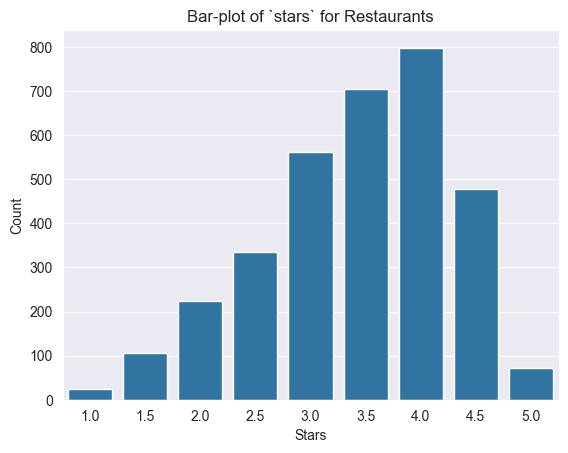

In [20]:
sns.countplot(data=restaurant_df, x="stars")
plt.title("Bar-plot of `stars` for Restaurants")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

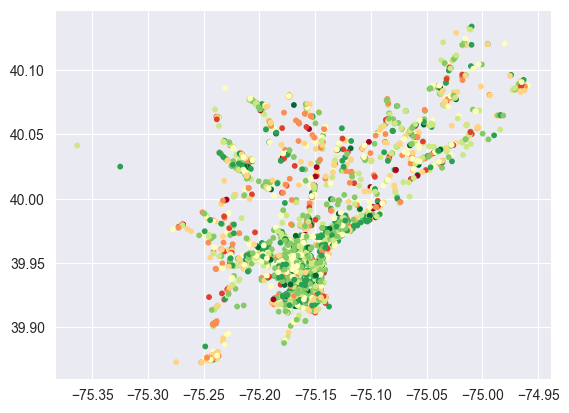

In [ ]:
plt.scatter(
    restaurant_df["longitude"],
    restaurant_df["latitude"],
    c=restaurant_df["stars"],
    cmap="RdYlGn",
    alpha=1,
    s=10,
)
plt.show()

Looking at how the restaurants are located in the city, there is no clear pattern that would determine their rating. It seems like the further one goes from the big cluster of them, they generally appear to have somewhat lower ratings, but there is nothing conclusive that we could say about it (seeing as there are also restaurants with bad reviews in the big luster). Furthermore, seeing as all the restaurants are located in one city, this feature seems not to have that big of an importance. We will see this more when we compute the correlation between these two attributes and the target variable (at least linear importance). But looking at this logically, the location of the restaurant should not in any way affect the rating of the restaurant, further improving our confidence that this attribute is redundant.


Now let us explore if there are any businesses that have a very low number of reviews. If there are, we may want to discard them, as a lack of reviews may introduce undesired noise and lead to our model performing worse.


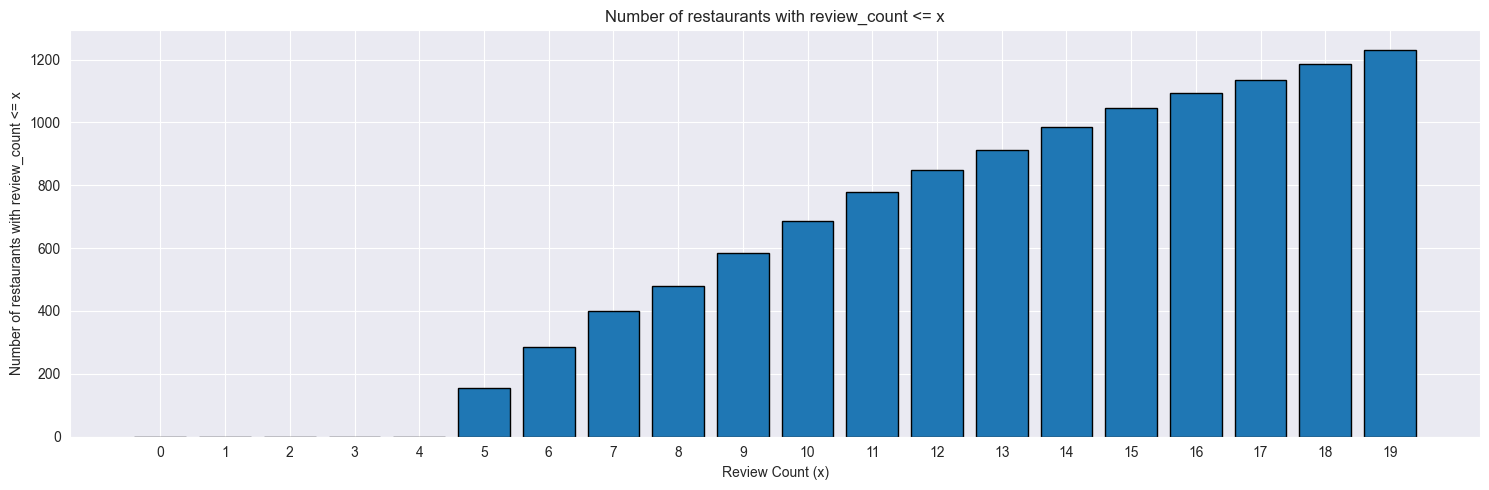

In [ ]:
max_x = 20
thresholds = list(range(max_x))
counts = [len(restaurant_df[restaurant_df["review_count"] <= x]) for x in thresholds]

plt.figure(figsize=(15, 5))
plt.bar(thresholds, counts, edgecolor="black")
plt.title("Number of restaurants with review_count <= x")
plt.xlabel("Review Count (x)")
plt.ylabel("Number of restaurants with review_count <= x")
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

## Categories


In [19]:
flattened_categories = [
    item for sublist in restaurant_df["categories"].str.split(", ") for item in sublist
]
category_counts = Counter(flattened_categories)

print(category_counts)

Counter({'Restaurants': 3049, 'Food': 1433, 'Pizza': 711, 'Nightlife': 689, 'Bars': 674, 'Sandwiches': 644, 'Breakfast & Brunch': 437, 'Coffee & Tea': 424, 'Italian': 317, 'Burgers': 288, 'American (New)': 288, 'Fast Food': 279, 'American (Traditional)': 248, 'Seafood': 241, 'Beer': 217, 'Wine & Spirits': 217, 'Mexican': 197, 'Grocery': 177, 'Cafes': 171, 'Delis': 165, 'Bakeries': 163, 'Salad': 160, 'Chinese': 153, 'Chicken Wings': 149, 'Cocktail Bars': 131, 'Desserts': 125, 'Specialty Food': 112, 'Cheesesteaks': 112, 'Pubs': 103, 'Sports Bars': 99, 'Diners': 90, 'Beer Bar': 83, 'Wine Bars': 79, 'Barbeque': 75, 'Juice Bars & Smoothies': 70, 'Steakhouses': 69, 'Gastropubs': 68, 'Convenience Stores': 63, 'Soul Food': 62, 'Bagels': 55, 'Food Delivery Services': 55, 'Soup': 53, 'Lounges': 51, 'Donuts': 50, 'Breweries': 46, 'Sushi Bars': 46, 'Shopping': 46, 'Hot Dogs': 40, 'Ethnic Food': 39, 'Vegetarian': 38, 'Comfort Food': 38, 'Mediterranean': 38, 'Arts & Entertainment': 35, 'Ice Cream & 

In [25]:
for category, count in category_counts.most_common(20):
    print(f"{category}: {count}")

Restaurants: 3049
Food: 1433
Pizza: 711
Nightlife: 689
Bars: 674
Sandwiches: 644
Breakfast & Brunch: 437
Coffee & Tea: 424
Italian: 317
Burgers: 288
American (New): 288
Fast Food: 279
American (Traditional): 248
Seafood: 241
Beer: 217
Wine & Spirits: 217
Mexican: 197
Grocery: 177
Cafes: 171
Delis: 165


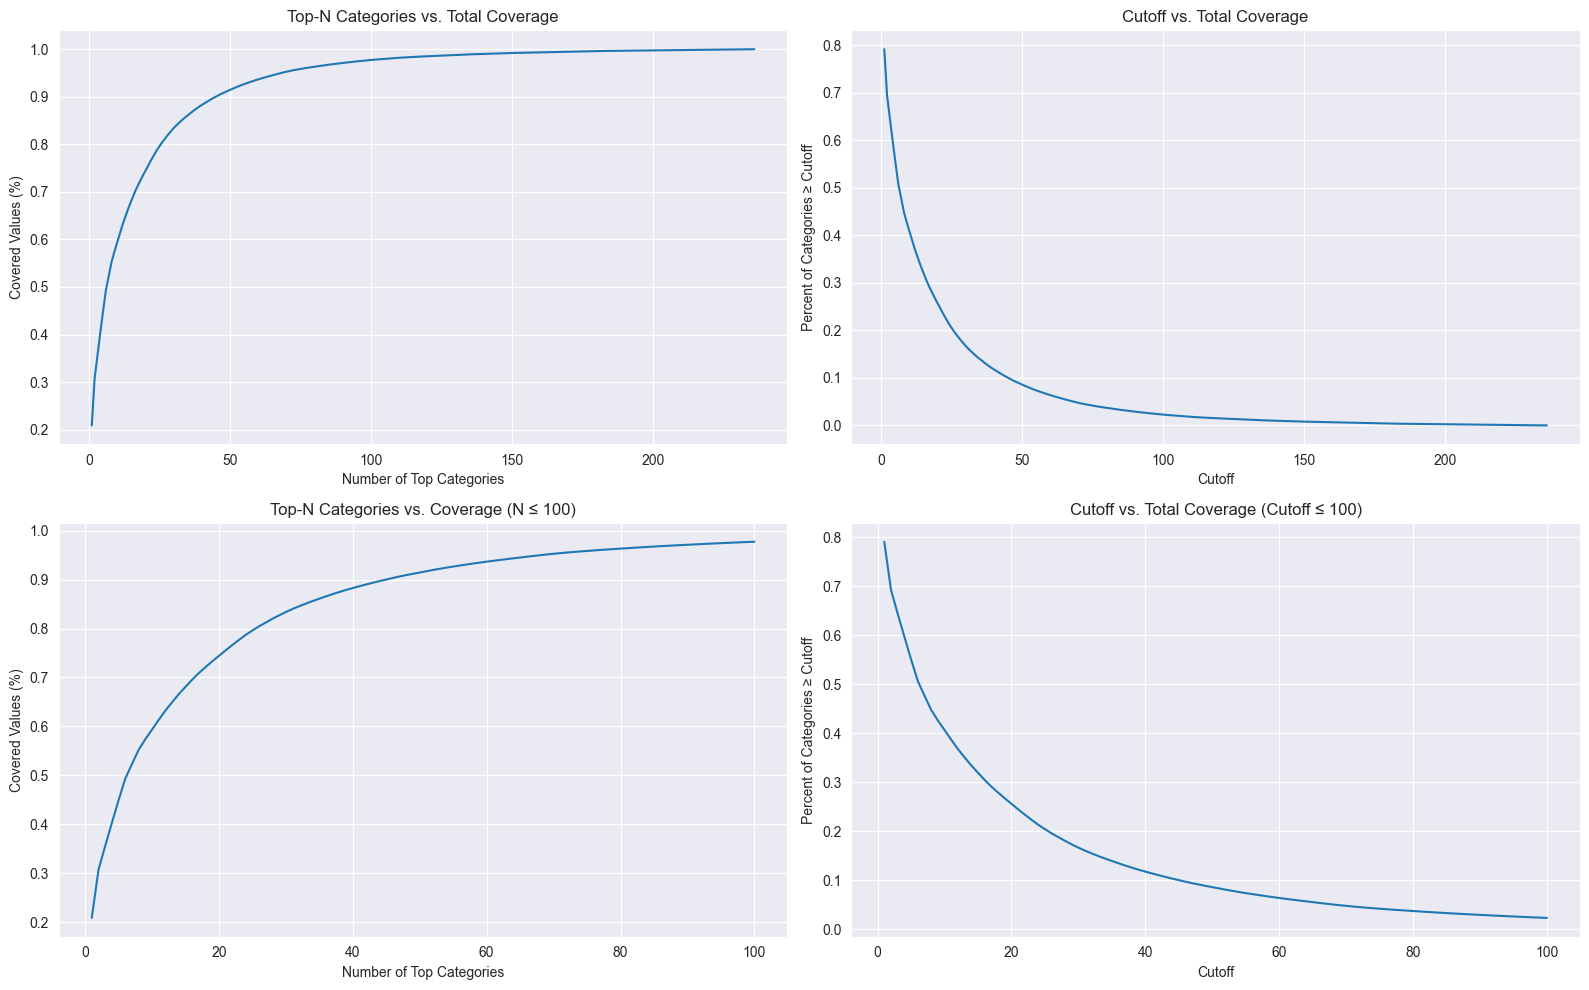

In [24]:
sorted_counts = sorted(category_counts.values(), reverse=True)
total = sum(sorted_counts)
n_values = list(range(1, len(sorted_counts) + 1))
cumulative = np.cumsum(sorted_counts)
coverage_percent = cumulative / total
cutoff_percent = 1 - coverage_percent

# Create 2x2 plot grid
_, axs = plt.subplots(2, 2, figsize=(16, 10))

# Top-Left: Full Top-N Coverage
axs[0, 0].plot(n_values, coverage_percent)
axs[0, 0].set_title("Top-N Categories vs. Total Coverage")
axs[0, 0].set_xlabel("Number of Top Categories")
axs[0, 0].set_ylabel("Covered Values (%)")
axs[0, 0].grid(True)

# Update Top-Right plot: Cutoff vs Categories (percent on x-axis)
axs[0, 1].plot(n_values, cutoff_percent)
axs[0, 1].set_title("Cutoff vs. Total Coverage")
axs[0, 1].set_xlabel("Cutoff")
axs[0, 1].set_ylabel("Percent of Categories ≥ Cutoff")
axs[0, 1].grid(True)

axs[1, 0].plot(n_values[:100], coverage_percent[:100])
axs[1, 0].set_title("Top-N Categories vs. Coverage (N ≤ 100)")
axs[1, 0].set_xlabel("Number of Top Categories")
axs[1, 0].set_ylabel("Covered Values (%)")
axs[1, 0].grid(True)

axs[1, 1].plot(n_values[:100], cutoff_percent[:100])
axs[1, 1].set_title("Cutoff vs. Total Coverage (Cutoff ≤ 100)")
axs[1, 1].set_xlabel("Cutoff")
axs[1, 1].set_ylabel("Percent of Categories ≥ Cutoff")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

The total number of categories is too big to realistically include all of them, least we want to have a huge number of features. Looking at the graphs, we can see that if we choose a cutoff value of ~30 we will retain >80% of all categories count. As a rule of thumb we will try to follow the [law of 80/20](https://en.wikipedia.org/wiki/Pareto_principle), which is why we will select top 29 categories, and treat all the rest as "Other".

This will result in us having 30 binary (one-hot encoded) features representing the categories of the restaurants. We believe this is a good starting point, as there are not too many nor to little features, and most of the values are accounted for.


# Combined data


In [ ]:
full_df = pd.merge(restaurant_df, reviews_df, how="left", on="business_id")
full_df.rename(
    columns={"stars_x": "restaurant_stars", "stars_y": "stars"}, inplace=True
)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326073 entries, 0 to 326072
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   business_id       326073 non-null  object 
 1   name              326073 non-null  object 
 2   address           326073 non-null  object 
 3   city              326073 non-null  object 
 4   state             326073 non-null  object 
 5   postal_code       326073 non-null  object 
 6   latitude          326073 non-null  float64
 7   longitude         326073 non-null  float64
 8   restaurant_stars  326073 non-null  float64
 9   review_count      326073 non-null  int64  
 10  is_open           326073 non-null  int64  
 11  attributes        325781 non-null  object 
 12  categories        326073 non-null  object 
 13  hours             314306 non-null  object 
 14  review_id         326073 non-null  object 
 15  user_id           326073 non-null  object 
 16  stars             32

In [27]:
full_df["stars"].hasnans

False

In [ ]:
full_df.drop(
    [
        "business_id",
        "name",
        "address",
        "city",
        "postal_code",
        "attributes",
        "categories",
        "hours",
        "user_id",
        "useful",
        "funny",
        "cool",
        "date",
    ],
    axis=1,
    inplace=True,
)

In [ ]:
full_df[["latitude", "longitude", "restaurant_stars", "review_count", "stars"]].corr()